# Assignment: Video Quality Inference

To this point in the class, you have learned various techniques for leading and analyzing packet captures of various types, generating features from those packet captures, and training and evaluating models using those features.

In this assignment, you will put all of this together, using a network traffic trace to train a model to automatically infer video quality of experience from a labeled traffic trace.

## Part 1: Warmup

The first part of this assignment builds directly on the hands-on activities but extends them slightly.

### Extract Features from the Network Traffic

Load the `netflix.pcap` file, which is a packet trace that includes network traffic. 

Click [here](https://github.com/noise-lab/ml-systems/blob/main/docs/notebooks/data/netflix.pcap) to download `netflix.pcap`.


In [10]:
import pandas as pd
from netml.pparser.parser import PCAP
import ipaddress

pc = PCAP(pcap_file="netflix.pcap")
pc.pcap2pandas()
df = pc.df

### Identifying the Service Type

Use the DNS traffic to filter the packet trace for Netflix traffic.

In [11]:
NF_DOMAINS = ["nflxvideo","netflix","nflxso","nflxext"]
nfre = '|'.join(NF_DOMAINS)
nf_dns = df[(df["is_dns"]) & (df["dns_query"].astype(str).str.contains(nfre, regex=True, case=False, na=False))]
nf_dns.head(5)

,datetime,dns_query,dns_resp,ip_dst,ip_dst_int,ip_src,ip_src_int,is_dns,length,mac_dst,mac_dst_int,mac_src,mac_src_int,port_dst,port_src,protocol,time,time_normed
86,2018-02-11 08:10:02,"(www.netflix.com.,)",None,128.93.77.234,2.153598e+09,192.168.43.72,3.232247e+09,True,75,a0:ce:c8:0d:2b:a7,176809980013479,e4:ce:8f:01:4c:54,251575813622868,53.0,43209.0,UDP,1518358202.362996,1.828314
87,2018-02-11 08:10:02,"(assets.nflxext.com.,)",None,128.93.77.234,2.153598e+09,192.168.43.72,3.232247e+09,True,78,a0:ce:c8:0d:2b:a7,176809980013479,e4:ce:8f:01:4c:54,251575813622868,53.0,28162.0,UDP,1518358202.363168,1.828486
88,2018-02-11 08:10:02,"(codex.nflxext.com.,)",None,128.93.77.234,2.153598e+09,192.168.43.72,3.232247e+09,True,77,a0:ce:c8:0d:2b:a7,176809980013479,e4:ce:8f:01:4c:54,251575813622868,53.0,48245.0,UDP,1518358202.363441,1.828759
89,2018-02-11 08:10:02,"(customerevents.netflix.com.,)",None,128.93.77.234,2.153598e+09,192.168.43.72,3.232247e+09,True,86,a0:ce:c8:0d:2b:a7,176809980013479,e4:ce:8f:01:4c:54,251575813622868,53.0,4046.0,UDP,1518358202.363675,1.828993
90,2018-02-11 08:10:02,"(ipv4-c001-cdg001-ix.1.oca.nflxvideo.net.,)",None,128.93.77.234,2.153598e+09,192.168.43.72,3.232247e+09,True,99,a0:ce:c8:0d:2b:a7,176809980013479,e4:ce:8f:01:4c:54,251575813622868,53.0,48058.0,UDP,1518358202.363921,1.829239


### Generate Statistics

Generate statistics and features for the Netflix traffic flows. Use the `netml` library or any other technique that you choose to generate a set of features that you think would be good features for your model. 

In [12]:
import re

def get_ips(cell):
    if pd.isna(cell):
        return []
    
    out = []
    text = str(cell)

    matches = re.findall(r'[A-Fa-f0-9:.]+', text) # Match v4 and v6

    for x in matches:
        try:
            ip = ipaddress.ip_address(x)
            out.append(str(ip))
        except ValueError:
            pass

    return out

nf_ips = set()
for resp in nf_dns["dns_resp"]:
    if pd.notna(resp):
        ips = get_ips(resp)
        nf_ips.update(ips)

nf = df[df["ip_src"].isin(nf_ips) | df["ip_dst"].isin(nf_ips)].copy()
nf["datetime"] = pd.to_datetime(nf["datetime"])

flow_stats = (
    # group by flows
    nf.groupby(["ip_src","ip_dst","port_src","port_dst","protocol"]).agg(
        flow_start=("datetime","min"),
        flow_end=("datetime","max"),
        n_packets=("length","count"),
        n_bytes=("length","sum"),
        mean_pkt_size=("length","mean"),
        std_pkt_size=("length","std"),
    ).reset_index()
)

flow_stats["duration_s"] = (flow_stats["flow_end"] - flow_stats["flow_start"]).dt.total_seconds()
flow_stats["bytes_per_sec"] = flow_stats["n_bytes"] / flow_stats["duration_s"]
flow_stats["pkts_per_sec"] = flow_stats["n_packets"] / flow_stats["duration_s"]

reverse_bytes = {
    (r.ip_dst, r.ip_src, r.port_dst, r.port_src, r.protocol): r.n_bytes
    for _, r in flow_stats.iterrows()
}

ratios=[]
for _, r in flow_stats.iterrows():
    key_rev = (r.ip_dst, r.ip_src, r.port_dst, r.port_src, r.protocol)
    rev_val = reverse_bytes.get(key_rev, None)
    if rev_val and rev_val > 0:
        ratios.append(max(r.n_bytes, rev_val) / rev_val)
    else:
        ratios.append(pd.NA)

flow_stats["down_up_ratio"] = ratios

**Write a brief justification for the features that you have chosen.**

Feature selected are based on video streaming characteristics.
Flow duration: Video streaming sessions are long-lived flows. DNS, etc. are short.
No. of packets/bytes: How sustained the streaming was?
Mean and std. packet size: Server->Client downstream packets are large (mostly MTU sized). 
Bytes/second nad packets/second: Throughput. Its a quality metric important for streaming.
Downstream/upstream ratio: Downstream dominates. 

### Inferring Segment downloads

In addition to the features that you could generate using the `netml` library or similar, add to your feature vector a "segment downloads rate" feature, which indicates the number of video segments downloaded for a given time window.

Note: If you are using the `netml` library, generating features with `SAMP` style options may be useful, as this option gives you time windows, and you can then simply add the segment download rate to that existing dataframe.

In [13]:
nf = nf.sort_values("datetime")
segment_stats = []

for key, grp in nf.groupby(["ip_src","ip_dst","port_src","port_dst","protocol"]):

    grp = grp.copy()
    grp["time_gap"] = grp["datetime"].diff().dt.total_seconds()
    grp["segment"] = (grp["time_gap"] >= 1.0).astype(int)

    seg_count = grp["segment"].sum() + 1  

    flow_duration = (grp["datetime"].max() - grp["datetime"].min()).total_seconds()
    seg_rate = seg_count / flow_duration

    segment_stats.append({
        "ip_src": key[0],
        "ip_dst": key[1],
        "port_src": key[2],
        "port_dst": key[3],
        "protocol": key[4],
        "segment_count": seg_count,
        "segment_download_rate": seg_rate
    })

segment_stats_df = pd.DataFrame(segment_stats)
flow_stats = flow_stats.merge(segment_stats_df, on=["ip_src","ip_dst","port_src","port_dst","protocol"], how="left")

print(flow_stats)

            ip_src          ip_dst  port_src  port_dst protocol  \
0    192.168.43.72  198.38.120.130   58451.0     443.0      TCP   
1    192.168.43.72  198.38.120.130   58452.0     443.0      TCP   
2    192.168.43.72  198.38.120.130   58453.0     443.0      TCP   
3    192.168.43.72  198.38.120.130   58480.0     443.0      TCP   
4    192.168.43.72  198.38.120.134   58496.0     443.0      TCP   
..             ...             ...       ...       ...      ...   
105  52.210.19.176   192.168.43.72     443.0   58461.0      TCP   
106  52.210.19.176   192.168.43.72     443.0   58462.0      TCP   
107  52.210.19.176   192.168.43.72     443.0   58463.0      TCP   
108  52.210.19.176   192.168.43.72     443.0   58479.0      TCP   
109   52.48.148.78   192.168.43.72     443.0   58508.0      TCP   

             flow_start            flow_end  n_packets  n_bytes  \
0   2018-02-11 08:10:02 2018-02-11 08:10:17         12     1064   
1   2018-02-11 08:10:02 2018-02-11 08:10:17         11      9

## Part 2: Video Quality Inference

You will now load the complete video dataset from a previous study to train and test models based on these features to automatically infer the quality of a streaming video flow.

For this part of the assignment, you will need two pickle files, which we provide for you by running the code below:

```

!gdown 'https://drive.google.com/uc?id=1N-Cf4dJ3fpak_AWgO05Fopq_XPYLVqdS' -O netflix_session.pkl
!gdown 'https://drive.google.com/uc?id=1PHvEID7My6VZXZveCpQYy3lMo9RvMNTI' -O video_dataset.pkl

```

### Load the File

Load the video dataset pickle file.

In [14]:
import pandas as pd
from netml.pparser.parser import PCAP
import ipaddress
df = pd.read_pickle("netflix_dataset.pkl")
print(df.head())

                                    10_EWMA_chunksizes  10_avg_chunksize  \
208  [[4380.0], [4380.0], [19682.095238095237], [23...          148947.1   
209  [[179260.0], [130204.0], [49666.09523809524], ...           91984.2   
210  [[317962.0], [83192.4], [170850.7619047619], [...          147725.0   
211  [[396800.0], [98961.6], [246910.09523809524], ...          246420.6   
212  [[325264.0], [331102.4], [365584.38095238095],...          336681.0   

     10_chunksizes_50  10_chunksizes_50R  10_chunksizes_75  10_chunksizes_75R  \
208           43473.0            43473.0          185098.0           185098.0   
209          101882.0           101882.0          122323.0           122323.0   
210          111373.0           111373.0          224157.0           224157.0   
211          297522.0           297522.0          330737.5           330737.5   
212          354461.0           354461.0          399719.5           399719.5   

     10_chunksizes_85  10_chunksizes_85R  10_chunksizes_

### Clean the File

1. The dataset contains video resolutions that are not valid. Remove entries in the dataset that do not contain a valid video resolution. Valid resolutions are 240, 360, 480, 720, 1080.

In [15]:
valid_res_set = [240, 360, 480, 720, 1080]
df = df[df["resolution"].isin(valid_res_set)]

2. The file also contains columns that are unnecessary (in fact, unhelpful!) for performing predictions. Identify those columns, and remove them.

In [16]:
drop_cols = []

drop_cols += [c for c in df.columns if "_id" in c]
drop_cols += [c for c in df.columns if "Flag" in c] 
drop_cols += [c for c in df.columns if "IdleTime" in c]
drop_cols += [c for c in df.columns if "index" in c.lower()]
drop_cols += df.select_dtypes(include=["object"]).columns.tolist()

print(drop_cols)

df_clean = df.drop(columns=drop_cols).copy()

x = df_clean.drop(columns=["resolution"])
y = df_clean["resolution"]

['deployment_session_id', 'home_id', 'session_id', 'video_id', 'serverAckFlags', 'serverFinFlags', 'serverPshFlags', 'serverRstFlags', 'serverSynFlags', 'serverUrgFlags', 'userAckFlags', 'userFinFlags', 'userPshFlags', 'userRstFlags', 'userSynFlags', 'userUrgFlags', 'serverIdleTime', 'userIdleTime', 'index', '10_EWMA_chunksizes', 'deployment_session_id', 'home_id', 'quality', 'session_id', 'video_id', 'service']


**Briefly explain why you removed those columns.**

1. We don't need IDs like home ID, deployment ID, session ID etc.
2. synFlags, userFlags, etc. are also not part of the actual streaming
3. Idle time is just the amount of time the client/server was idle
4. Fields like index don't possess any useful information
5. Any non-numerical fields. 

### Prepare Your Data

Prepare your data matrix, determine your features and labels, and perform a train-test split on your data.

In [17]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    x, y,
    test_size=0.2,
    stratify=y
)

### Train and Tune Your Model

1. Select a model of your choice.
2. Train the model using your training data.

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(random_state=42)
rf.fit(x_train, y_train)


RandomForestClassifier(random_state=42)

### Tune Your Model

Perform hyperparameter tuning to find optimal parameters for your model.

In [19]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distributions = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(5, 20),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5)
}
search = RandomizedSearchCV(
    rf,
    param_distributions=param_distributions,
    n_iter=20,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=1
)
search.fit(x_train, y_train)

best_model = search.best_estimator_

Fitting 3 folds for each of 20 candidates, totalling 60 fits


### Evaluate Your Model

Evaluate your model accuracy according to the following metrics:

1. Accuracy
2. F1 Score
3. Confusion Matrix
4. ROC/AUC

In [21]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np

y_pred = best_model.predict(x_test)

acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

f1 = f1_score(y_test, y_pred, average="macro")
print("F2:", f1)

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

y_prob = best_model.predict_proba(x_test)
classes = best_model.classes_ 
y_test_bin = label_binarize(y_test, classes=classes)

roc_auc = roc_auc_score(y_test_bin, y_prob, average="macro", multi_class="ovr")
print("ROC-AUC:", roc_auc)

Accuracy: 0.9492462311557789
F2: 0.8927943862662853
Confusion Matrix:
 [[ 208   30   85   17    0]
 [  28  727  126   14    0]
 [  14   20 5827   34    2]
 [   4    2   93 1772   21]
 [   0    0    0   15  911]]
ROC-AUC: 0.9951807119373586


## Part 3: Predict the Ongoing Resolution of a Real Netflix Session

Now that you have your model, it's time to put it in practice!

Use a preprocessed Netflix video session to infer **and plot** the resolution at 10-second time intervals.

Selected Session: 60c183c37225d39e49aaf5c4d5126272


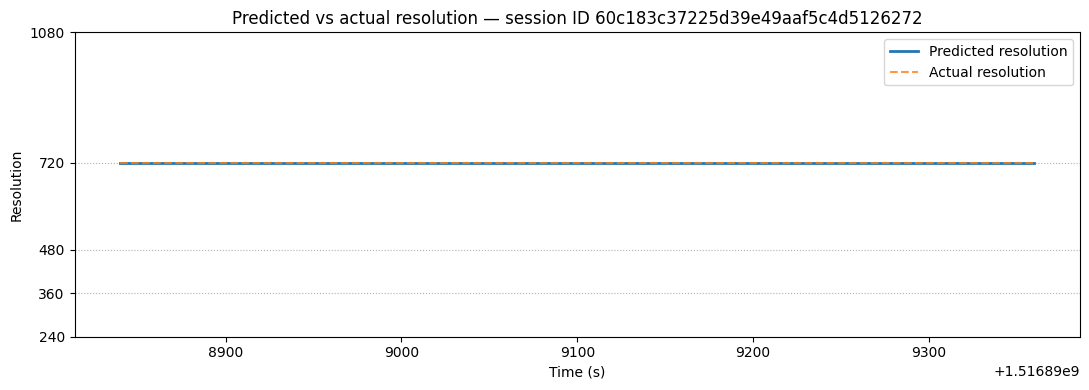

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

test_raw = df.loc[x_test.index].copy()

time_col = "absolute_timestamp" 
sess_col = "session_id"

test_raw[time_col] = pd.to_numeric(test_raw[time_col], errors="coerce").fillna(0)
test_raw["time_bin"] = (test_raw[time_col] // 10 * 10).astype(int)

selected_session = test_raw[sess_col].value_counts().idxmax()
test_session = test_raw[test_raw[sess_col] == selected_session].copy()
print("Selected Session:", selected_session)

feat_cols = list(x_train.columns)
agg_test_session = (
    test_session.groupby("time_bin")[feat_cols]
       .median()
       .reset_index()
)
x_agg_test_session = agg_test_session[feat_cols].copy()

agg_test_session["pred_resolution"] = best_model.predict(x_agg_test_session)

# Selecting most frequest resolution in time bins for that session
actual_resolution = (
    test_session.groupby("time_bin")["resolution"]
       .agg(lambda s: s.mode().iloc[0] if not s.mode().empty else np.nan)
       .reset_index()
)
final_plot_df = agg_test_session.merge(actual_resolution, on="time_bin", how="left")

plt.figure(figsize=(11,4))
plt.step(final_plot_df["time_bin"], final_plot_df["pred_resolution"], where="post", linewidth=2, label="Predicted resolution")
plt.step(final_plot_df["time_bin"], final_plot_df["resolution"], where="post", linestyle="--", alpha=0.8, label="Actual resolution")
plt.yticks([240, 360, 480, 720, 1080])
plt.xlabel("Time (s)")
plt.ylabel("Resolution")
plt.title(f"Predicted vs actual resolution — session ID {selected_session}")
plt.grid(True, axis="y", linestyle=":")
plt.legend()
plt.tight_layout()
plt.show()